# 2025年华数杯C题：可调控生物节律的LED光源研究

## 题目概述
本题目要求分析LED光源的光谱特性及其对生物节律的影响，通过数学建模方法解决LED光源设计和优化问题。

## 数据说明
- Problem 1: 基础光谱数据（波长vs光强）
- Problem 2: LED光谱功率分布数据（蓝、绿、红、暖白、冷白LED）
- Problem 3: 太阳光谱数据（5:30-19:30不同时间点）
- Problem 4: 人体测试数据（11名被试者，3晚数据）

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy import integrate
import warnings
warnings.filterwarnings('ignore')
from matplotlib.patches import Polygon
import seaborn as sns
from scipy.optimize import minimize_scalar, minimize
from scipy.interpolate import interp1d
import luxpy as lx
import colour
# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
print("正在读取数据...")
problem1_data = pd.read_excel('附录.xlsx', sheet_name='Problem 1')
problem2_data = pd.read_excel('附录.xlsx', sheet_name='Problem 2_LED_SPD')
problem3_data = pd.read_excel('附录.xlsx', sheet_name='Problem 3 SUN_SPD')
problem4_data = pd.read_excel('附录.xlsx', sheet_name='Problem 4')

print("数据读取完成!")
print(f"Problem 1 数据形状: {problem1_data.shape}")
print(f"Problem 2 数据形状: {problem2_data.shape}")
print(f"Problem 3 数据形状: {problem3_data.shape}")
print(f"Problem 4 数据形状: {problem4_data.shape}")

正在读取数据...
数据读取完成!
Problem 1 数据形状: (401, 2)
Problem 2 数据形状: (401, 6)
Problem 3 数据形状: (401, 16)
Problem 4 数据形状: (1065, 33)
数据读取完成!
Problem 1 数据形状: (401, 2)
Problem 2 数据形状: (401, 6)
Problem 3 数据形状: (401, 16)
Problem 4 数据形状: (1065, 33)


---
## 问题1：光谱数据分析与色温计算

### 问题描述
分析给定光谱数据的光学特性，计算CCT，Duv,Rg,Rf,mel-Dev.
### 解决方案


In [130]:

intensity = problem1_data['光强'].values

wavelengths = np.arange(380, 781)  # 380-780nm

cie_xyz=pd.read_csv('CIE_xyz_1931_2deg.csv').iloc[20:421]

# 提取波长和光强数据
# 处理波长列的单位信息

x_bar = cie_xyz['x'].values
y_bar = cie_xyz['y'].values
z_bar = cie_xyz['z'].values

## 1. 计算CCT

In [131]:
def planck_law(lam_um, T):
    """
    计算黑体光谱辐射出射度（国际单位制：λ→米，B→W·m⁻³）
    
    参数：
    lam_um : 波长，单位 um
    T     : 绝对温度，单位 K
    
    返回：
    B     : 光谱辐射出射度，单位 W·m⁻³
    """
    # 物理常数（精确值，2019年后定义）
    h = 6.62607015e-34  # 普朗克常数，J·s（1 J = 1 W·s）
    c = 2.99792458e8    # 光速，m/s
    k = 1.380649e-23    # 玻尔兹曼常数，J/K
    
    # 计算辐射常数
    c1 = 2 * np.pi * h * c**2  # 第一辐射常数，W·m²
    c2 = h * c / k              # 第二辐射常数，m·K
    
    # 将微米转换为米
    lam_m = lam_um * 1e-6
    
    # 普朗克公式核心计算
    B = c1 / (lam_m**5 * (np.exp(c2 / (lam_m * T)) - 1))
    
    return B
def calculate_xyz(intensity, cie_xyz):
    """
    计算XYZ三刺激值和色品坐标
    
    参数：
    intensity : 光谱强度数组
    cie_xyz   : 包含x, y, z颜色匹配函数的字典
    
    返回：
    X, Y, Z, x, y : 三刺激值和色品坐标
    """
    wavelengths = np.arange(380, 781)  # 380-780nm
    x_bar, y_bar, z_bar = cie_xyz['x'], cie_xyz['y'], cie_xyz['z']
    
    # 归一化常数
    k = 100 / np.trapz(intensity * y_bar, wavelengths)
    
    # 计算XYZ三刺激值
    X = k * np.trapz(intensity * x_bar, wavelengths)
    Y = k * np.trapz(intensity * y_bar, wavelengths)
    Z = k * np.trapz(intensity * z_bar, wavelengths)
    
    # 计算色品坐标
    total = X + Y + Z
    if total == 0:
        return 0, 0
    
    x = X / total
    y = Y / total
    
    return  x, y


黑体轨迹计算程序

1. 绘制黑体轨迹...
计算黑体轨迹: 1000K - 15000K, 步长 200K
图片已保存为 'blackbody_locus.png'
图片已保存为 'blackbody_locus.png'


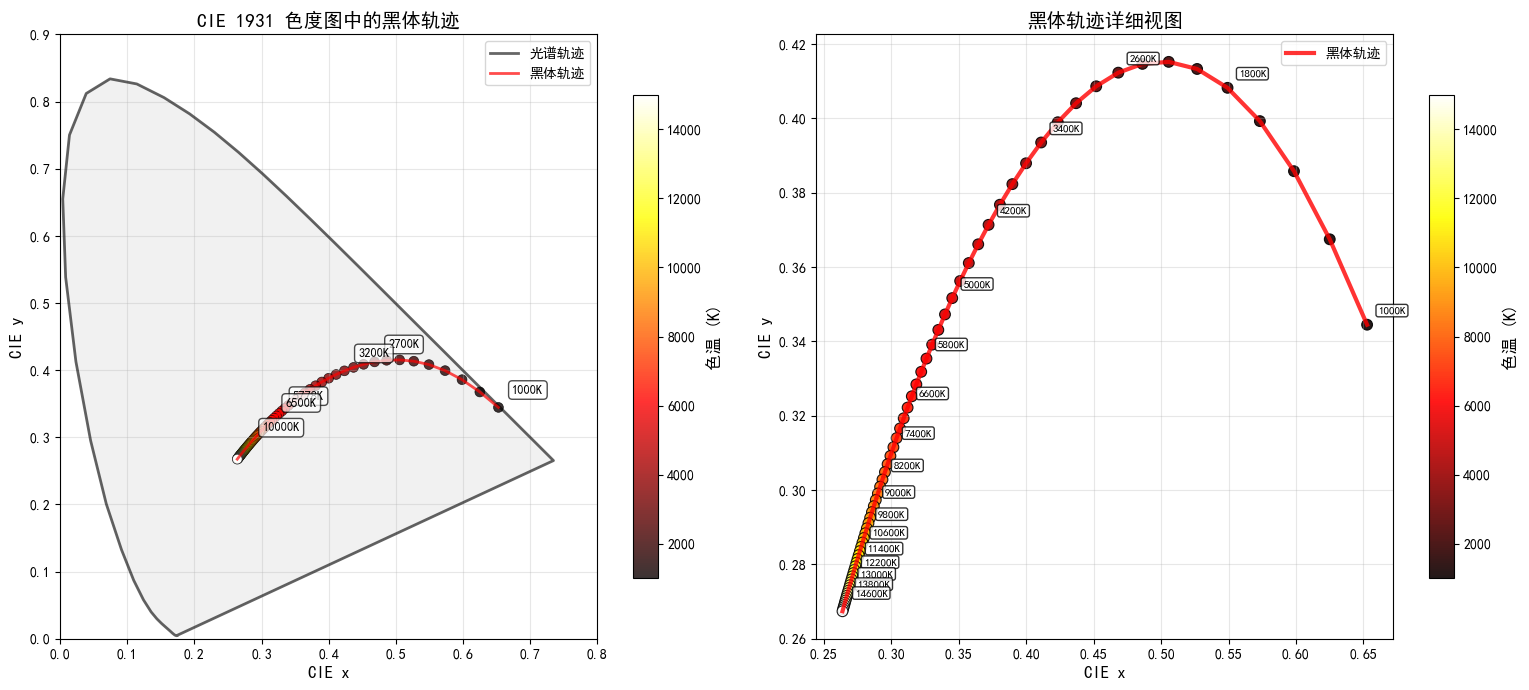


关键温度点的色品坐标:
温度(K)		x		y
------------------------------
1000		0.6527		0.3445
2700		0.4682		0.4123
3200		0.4234		0.3990
5778		0.3260		0.3354
6500		0.3151		0.3252
10000		0.2807		0.2884

2. 分析特定温度点...


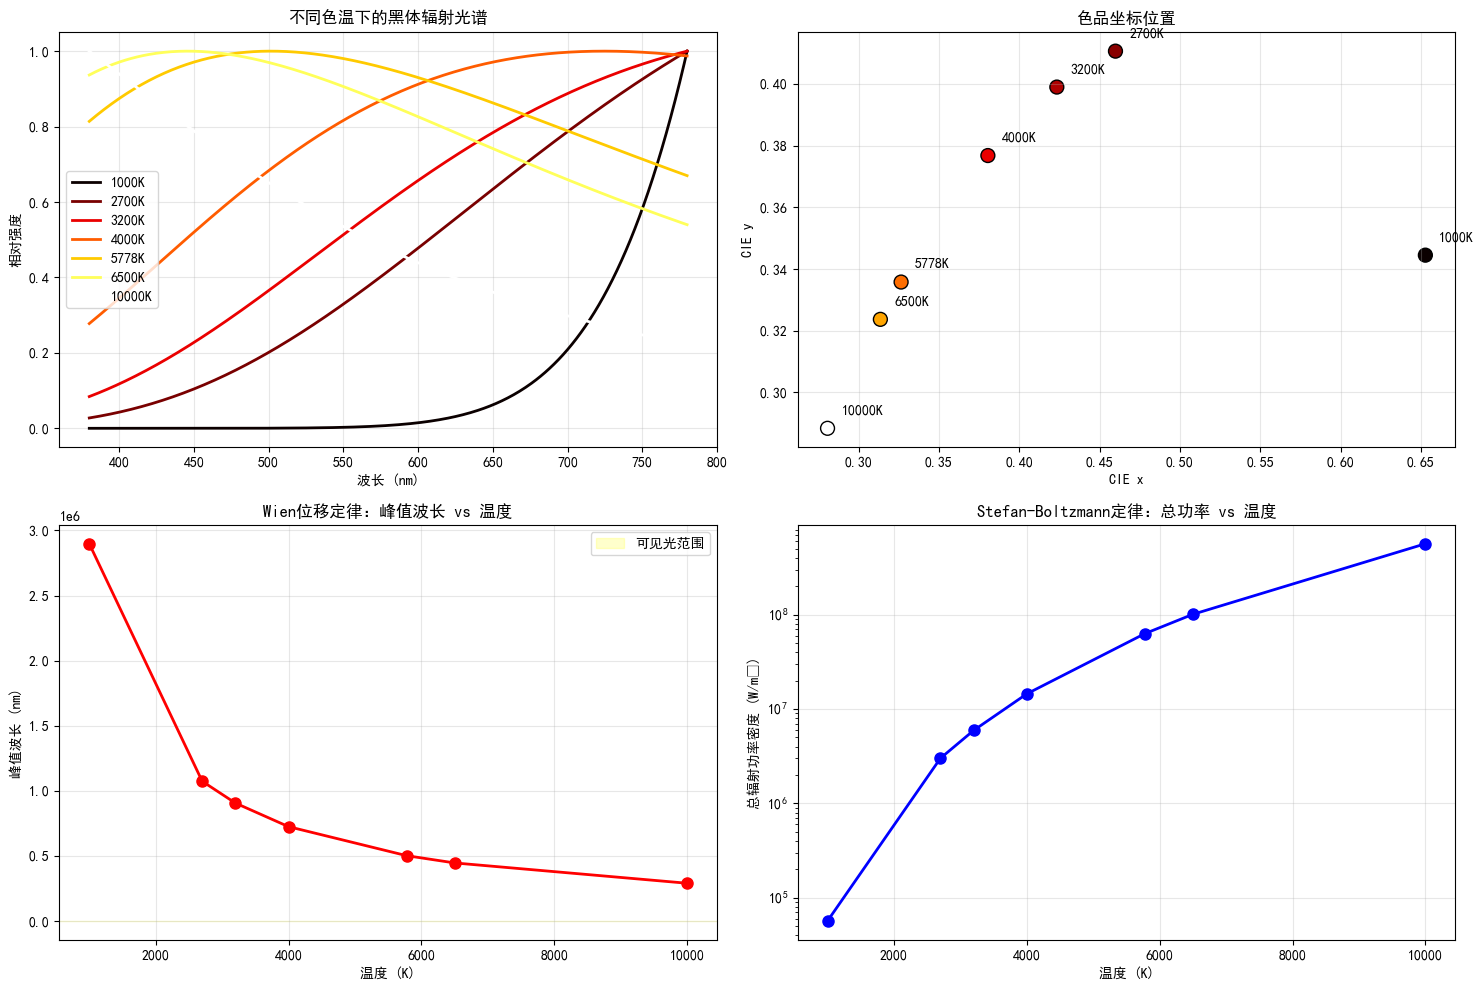


黑体辐射分析结果:
温度(K)    CIE x    CIE y    峰值波长(nm)     总功率(W/m²)      
------------------------------------------------------------
1000     0.6527   0.3445   2898000.0    5.67e+04       
2700     0.4599   0.4106   1073333.3    3.01e+06       
3200     0.4234   0.3990   905625.0     5.95e+06       
4000     0.3805   0.3768   724500.0     1.45e+07       
5778     0.3265   0.3358   501557.6     6.32e+07       
6500     0.3136   0.3237   445846.2     1.01e+08       
10000    0.2807   0.2884   289800.0     5.67e+08       

程序执行完成！


In [132]:
def calculate_blackbody_spectrum(T, wavelengths):
    """
    计算指定温度下的黑体辐射光谱
    
    参数：
    T : 温度 (K)
    wavelengths : 波长数组 (nm)
    
    返回：
    spectrum : 光谱强度数组
    """
    spectrum = []
    for wl in wavelengths:
        lam_um = wl / 1000.0  # 转换为微米
        intensity = planck_law(lam_um, T)
        spectrum.append(intensity)
    
    return np.array(spectrum)

def plot_blackbody_locus(T_range=(1000, 20000, 200), save_fig=True):
    """
    绘制黑体轨迹图
    
    参数：
    T_range : 温度范围 (起始温度, 结束温度, 步长)
    save_fig : 是否保存图片
    """
    wavelengths = np.arange(380, 781)  # 380-780nm
    # 加载CIE颜色匹配函数
    cie_data = pd.read_csv('CIE_xyz_1931_2deg.csv').iloc[20:421]
    
    # 计算不同温度下的色品坐标
    temperatures = np.arange(T_range[0], T_range[1] + T_range[2], T_range[2])
    x_coords = []
    y_coords = []
    
    print(f"计算黑体轨迹: {T_range[0]}K - {T_range[1]}K, 步长 {T_range[2]}K")
    
    for i, T in enumerate(temperatures):
        spectrum = calculate_blackbody_spectrum(T, wavelengths)
        
        # 计算XYZ和色品坐标
        x, y = calculate_xyz(spectrum, cie_data)
        
        x_coords.append(x)
        y_coords.append(y)
    
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    
    # 创建图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # 绘制CIE色度图的光谱轨迹边界
    spectral_locus_x = []
    spectral_locus_y = []
    
    for wl in range(380, 701, 5):  # 光谱轨迹
        # 创建单色光谱
        mono_spectrum = np.zeros_like(wavelengths)
        idx = np.argmin(np.abs(wavelengths - wl))
        mono_spectrum[idx] = 1.0
        
        x, y = calculate_xyz(mono_spectrum, cie_data)
        spectral_locus_x.append(x)
        spectral_locus_y.append(y)
    
    # 添加紫红线（连接380nm和700nm）
    spectral_locus_x.append(spectral_locus_x[0])
    spectral_locus_y.append(spectral_locus_y[0])
    
    # 子图1：完整的CIE色度图 + 黑体轨迹
    ax1.plot(spectral_locus_x, spectral_locus_y, 'k-', linewidth=2, alpha=0.6, label='光谱轨迹')
    ax1.fill(spectral_locus_x, spectral_locus_y, color='lightgray', alpha=0.3)
    
    # 绘制黑体轨迹
    scatter = ax1.scatter(x_coords, y_coords, c=temperatures, cmap='hot', 
                         s=50, edgecolors='black', linewidths=0.5, alpha=0.8)
    ax1.plot(x_coords, y_coords, 'r-', linewidth=2, alpha=0.7, label='黑体轨迹')
    
    # 标注一些重要温度点
    important_temps = [1000, 2700, 3200, 5778, 6500, 10000]
    for temp in important_temps:
        if T_range[0] <= temp <= T_range[1]:
            idx = np.argmin(np.abs(temperatures - temp))
            ax1.annotate(f'{temp}K', 
                        (x_coords[idx], y_coords[idx]), 
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=9, ha='left',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    ax1.set_xlim(0, 0.8)
    ax1.set_ylim(0, 0.9)
    ax1.set_xlabel('CIE x', fontsize=12)
    ax1.set_ylabel('CIE y', fontsize=12)
    ax1.set_title('CIE 1931 色度图中的黑体轨迹', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_aspect('equal')
    
    # 添加颜色条
    cbar1 = plt.colorbar(scatter, ax=ax1, shrink=0.8)
    cbar1.set_label('色温 (K)', fontsize=12)
    
    # 子图2：黑体轨迹放大图
    ax2.plot(x_coords, y_coords, 'r-', linewidth=3, alpha=0.8, label='黑体轨迹')
    scatter2 = ax2.scatter(x_coords, y_coords, c=temperatures, cmap='hot', 
                          s=60, edgecolors='black', linewidths=0.8, alpha=0.9)
    
    # 标注更多温度点
    for i in range(0, len(temperatures), max(1, len(temperatures)//15)):
        temp = temperatures[i]
        ax2.annotate(f'{int(temp)}K', 
                    (x_coords[i], y_coords[i]), 
                    xytext=(8, 8), textcoords='offset points',
                    fontsize=8, ha='left',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    ax2.set_xlabel('CIE x', fontsize=12)
    ax2.set_ylabel('CIE y', fontsize=12)
    ax2.set_title('黑体轨迹详细视图', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 添加颜色条
    cbar2 = plt.colorbar(scatter2, ax=ax2, shrink=0.8)
    cbar2.set_label('色温 (K)', fontsize=12)
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig('blackbody_locus.png', dpi=300, bbox_inches='tight')
        print("图片已保存为 'blackbody_locus.png'")
    
    plt.show()
    
    # 输出一些关键数据点
    print("\n关键温度点的色品坐标:")
    print("温度(K)\t\tx\t\ty")
    print("-" * 30)
    for temp in important_temps:
        if T_range[0] <= temp <= T_range[1]:
            idx = np.argmin(np.abs(temperatures - temp))
            print(f"{temp}\t\t{x_coords[idx]:.4f}\t\t{y_coords[idx]:.4f}")

def analyze_color_temperature(T_list):
    """
    分析特定温度下的黑体辐射特性
    
    参数：
    T_list : 要分析的温度列表
    """
    cie_data = cie_xyz
    wavelengths = np.arange(380, 781)  # 380-780nm
    
    plt.figure(figsize=(15, 10))
    
    # 子图1：光谱分布
    plt.subplot(2, 2, 1)
    colors = plt.cm.hot(np.linspace(0, 1, len(T_list)))
    
    for i, T in enumerate(T_list):
        spectrum = calculate_blackbody_spectrum(T, wavelengths)
        # 归一化显示
        spectrum_norm = spectrum / np.max(spectrum)
        plt.plot(wavelengths, spectrum_norm, color=colors[i], 
                linewidth=2, label=f'{T}K')
    
    plt.xlabel('波长 (nm)')
    plt.ylabel('相对强度')
    plt.title('不同色温下的黑体辐射光谱')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图2：在CIE图中的位置
    plt.subplot(2, 2, 2)
    x_coords = []
    y_coords = []
    
    for T in T_list:
        spectrum = calculate_blackbody_spectrum(T, wavelengths)
        x, y = calculate_xyz(spectrum, cie_data)
        x_coords.append(x)
        y_coords.append(y)
    
    plt.scatter(x_coords, y_coords, c=T_list, cmap='hot', s=100, 
               edgecolors='black', linewidths=1)
    
    for i, T in enumerate(T_list):
        plt.annotate(f'{T}K', (x_coords[i], y_coords[i]), 
                    xytext=(10, 10), textcoords='offset points')
    
    plt.xlabel('CIE x')
    plt.ylabel('CIE y')
    plt.title('色品坐标位置')
    plt.grid(True, alpha=0.3)
    
    # 子图3：峰值波长随温度变化（Wien定律）
    plt.subplot(2, 2, 3)
    wien_wavelengths = [2.898e6 / T for T in T_list]  # Wien位移定律，结果为μm
    wien_wavelengths_nm = [w * 1000 for w in wien_wavelengths]  # 转换为nm
    
    plt.plot(T_list, wien_wavelengths_nm, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('温度 (K)')
    plt.ylabel('峰值波长 (nm)')
    plt.title('Wien位移定律：峰值波长 vs 温度')
    plt.grid(True, alpha=0.3)
    
    # 添加可见光范围
    plt.axhspan(380, 780, alpha=0.2, color='yellow', label='可见光范围')
    plt.legend()
    
    # 子图4：Stefan-Boltzmann定律
    plt.subplot(2, 2, 4)
    stefan_boltzmann = 5.670374419e-8  # W⋅m⋅K⁻⁴
    total_powers = [stefan_boltzmann * T**4 for T in T_list]
    
    plt.semilogy(T_list, total_powers, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('温度 (K)')
    plt.ylabel('总辐射功率密度 (W/m²)')
    plt.title('Stefan-Boltzmann定律：总功率 vs 温度')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 输出分析结果
    print("\n黑体辐射分析结果:")
    print("=" * 60)
    print(f"{'温度(K)':<8} {'CIE x':<8} {'CIE y':<8} {'峰值波长(nm)':<12} {'总功率(W/m²)':<15}")
    print("-" * 60)
    
    for i, T in enumerate(T_list):
        print(f"{T:<8} {x_coords[i]:<8.4f} {y_coords[i]:<8.4f} "
              f"{wien_wavelengths_nm[i]:<12.1f} {total_powers[i]:<15.2e}")


print("黑体轨迹计算程序")
print("=" * 50)
    
# 1. 绘制完整的黑体轨迹
print("\n1. 绘制黑体轨迹...")
plot_blackbody_locus(T_range=(1000, 15000, 200))
    
# 2. 分析特定温度点
print("\n2. 分析特定温度点...")
important_temperatures = [1000, 2700, 3200, 4000, 5778, 6500, 10000]
analyze_color_temperature(important_temperatures)
    
print("\n程序执行完成！")

In [133]:
def calculate_blackbody_spectrum(T, wavelengths):
    """
    计算指定温度下的黑体辐射光谱
    """
    spectrum = []
    for wl in wavelengths:
        lam_um = wl / 1000.0  # 转换为微米
        intensity = planck_law(lam_um, T)
        spectrum.append(intensity)
    
    return np.array(spectrum)

def generate_planck_locus(T_range=(1000, 20000), num_points=1000):
    """
    生成普朗克轨迹（黑体轨迹）数据
    
    参数：
    T_range : 温度范围 (起始温度, 结束温度)
    num_points : 轨迹点数
    
    返回：
    temperatures : 温度数组
    x_coords : x色品坐标数组
    y_coords : y色品坐标数组
    """
    # 加载CIE颜色匹配函数
    cie_data = pd.read_csv('CIE_xyz_1931_2deg.csv').iloc[20:421]
    wavelengths = np.arange(380, 781)  # 380-780nm
    
    # 使用对数空间分布温度点，在低温区域有更高密度
    temperatures = np.logspace(np.log10(T_range[0]), np.log10(T_range[1]), num_points)
    
    x_coords = []
    y_coords = []
    
    
    for i, T in enumerate(temperatures):
        spectrum = calculate_blackbody_spectrum(T, wavelengths)
        # 计算XYZ和色品坐标
        x, y = calculate_xyz(spectrum, cie_data)
        
        x_coords.append(x)
        y_coords.append(y)
    
    return np.array(temperatures), np.array(x_coords), np.array(y_coords)

class PlanckLocusInterpolator:
    """
    普朗克轨迹插值器类
    用于快速计算轨迹上的点和最近点搜索
    """
    
    def __init__(self, T_range=(1000, 20000), num_points=2000):
        """
        初始化插值器
        """
        self.temperatures, self.x_coords, self.y_coords = generate_planck_locus(T_range, num_points)
        
        # 创建插值函数
        self.x_interp = interp1d(self.temperatures, self.x_coords, kind='cubic', 
                                bounds_error=False, fill_value='extrapolate')
        self.y_interp = interp1d(self.temperatures, self.y_coords, kind='cubic', 
                                bounds_error=False, fill_value='extrapolate')
        
        # 创建反向插值（从坐标到温度）用于初始估计
        self.T_from_x = interp1d(self.x_coords, self.temperatures, kind='linear', 
                                bounds_error=False, fill_value='extrapolate')
        
    
    def get_xy_from_T(self, T):
        """
        根据温度获取色品坐标
        """
        x = self.x_interp(T)
        y = self.y_interp(T)
        return float(x), float(y)
    
    def distance_to_point(self, T, target_x, target_y):
        """
        计算温度T对应的轨迹点到目标点的距离
        """
        x, y = self.get_xy_from_T(T)
        return np.sqrt((x - target_x)**2 + (y - target_y)**2)

def find_cct_duv(xs, ys, planck_interpolator=None, method='optimization'):
    """
    计算相关色温(CCT)和色偏差(Duv)
    
    参数：
    xs, ys : 待测光源的色品坐标
    planck_interpolator : 普朗克轨迹插值器
    method : 计算方法 ('optimization' 或 'search')
    
    返回：
    CCT : 相关色温 (K)
    Duv : 色偏差
    ut, vt : 轨迹上最近点的坐标
    """
    if planck_interpolator is None:
        planck_interpolator = PlanckLocusInterpolator()
    
    if method == 'optimization':
        # 方法1: 优化算法寻找最近点
        # 初始估计
        T_init = planck_interpolator.T_from_x(xs)
        T_init = np.clip(T_init, 1000, 20000)  # 确保在合理范围内
        
        # 使用scipy优化找到最近点
        result = minimize_scalar(
            lambda T: planck_interpolator.distance_to_point(T, xs, ys),
            bounds=(1000, 20000),
            method='bounded',
            options={'xatol': 0.1}  # 温度精度0.1K
        )
        
        CCT = result.x
        ut, vt = planck_interpolator.get_xy_from_T(CCT)
        
    else:
        # 方法2: 直接搜索最小距离点
        distances = []
        for i, T in enumerate(planck_interpolator.temperatures):
            dist = planck_interpolator.distance_to_point(T, xs, ys)
            distances.append(dist)
        
        min_idx = np.argmin(distances)
        CCT = planck_interpolator.temperatures[min_idx]
        ut = planck_interpolator.x_coords[min_idx]
        vt = planck_interpolator.y_coords[min_idx]
    
    # 计算色偏差Duv
    distance = np.sqrt((ut - xs)**2 + (vt - ys)**2)
    
    # 计算符号：根据公式(2.11)
    # 如果待测点在轨迹上方(ys > vt)，Duv为正；下方为负
    sign = np.sign(ys - vt)
    Duv = sign * distance
    
    return CCT, Duv, ut, vt

def analyze_led_samples():
    """
    分析一组LED样品的CCT和Duv
    """
    x,y=calculate_xyz(intensity, cie_xyz)
    # 模拟一些LED样品的色品坐标
    led_samples = {
        'LED':(x,y)
    }
    
    # 创建普朗克轨迹插值器
    interpolator = PlanckLocusInterpolator(T_range=(1500, 15000), num_points=2000)
    
    # 分析结果
    results = []
    
    print("\nLED样品分析结果:")
    print("=" * 80)
    print(f"{'样品名称':<15} {'x':<8} {'y':<8} {'CCT(K)':<8} {'Duv':<10} {'轨迹点(x,y)':<20} {'有效性'}")
    print("-" * 80)
    
    for name, (x, y) in led_samples.items():
        try:
            CCT, Duv, ut, vt = find_cct_duv(x, y, interpolator)
            
            # 判断是否在有效范围内（|Duv| <= 0.054）
            is_valid = "有效" if abs(Duv) <= 0.054 else "超出范围"
            
            results.append({
                'name': name,
                'x': x,
                'y': y,
                'CCT': CCT,
                'Duv': Duv,
                'ut': ut,
                'vt': vt,
                'valid': is_valid
            })
            
            print(f"{name:<15} {x:<8.3f} {y:<8.3f} {CCT:<8.0f} {Duv:<10.4f} "
                  f"({ut:.3f},{vt:.3f})      {is_valid}")
            
        except Exception as e:
            print(f"{name:<15} 计算错误: {e}")
    
    return results, interpolator

def plot_cct_duv_analysis(results, interpolator):
    """
    可视化CCT和Duv分析结果
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # 子图1: CIE色度图 + 普朗克轨迹 + LED点
    ax1.plot(interpolator.x_coords, interpolator.y_coords, 'r-', 
             linewidth=3, alpha=0.8, label='普朗克轨迹')
    
    # 绘制LED样品点
    for result in results:
        x, y = result['x'], result['y']
        ut, vt = result['ut'], result['vt']
        
        # 样品点
        color = 'green' if result['valid'] == '有效' else 'red'
        ax1.scatter(x, y, s=120, c=color, edgecolors='black', 
                   linewidths=2, alpha=0.8, zorder=5)
        
        # 轨迹上的最近点
        ax1.scatter(ut, vt, s=60, c='blue', marker='x', 
                   linewidths=3, alpha=0.8, zorder=5)
        
        # 连接线（显示距离）
        ax1.plot([x, ut], [y, vt], 'k--', alpha=0.5, linewidth=1)
        
        # 标注
        ax1.annotate(f"{result['name']}\n{result['CCT']:.0f}K", 
                    (x, y), xytext=(10, 10), textcoords='offset points',
                    fontsize=9, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', 
                             facecolor='white', alpha=0.7))
    
    ax1.set_xlim(0.25, 0.5)
    ax1.set_ylim(0.25, 0.45)
    ax1.set_xlabel('CIE x', fontsize=12)
    ax1.set_ylabel('CIE y', fontsize=12)
    ax1.set_title('LED在CIE色度图中的位置与CCT分析', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_aspect('equal')
    
    # 添加图例说明
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
               markersize=10, label='有效LED (|Duv|≤0.054)', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='超出范围LED', markeredgecolor='black'),
        Line2D([0], [0], marker='x', color='blue', markersize=10, 
               label='轨迹上最近点', markeredgewidth=3),
        Line2D([0], [0], color='k', linestyle='--', alpha=0.5, 
               label='距离连线')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    # 子图2: CCT vs Duv 散点图
    cct_values = [r['CCT'] for r in results]
    duv_values = [r['Duv'] for r in results]
    colors = ['green' if r['valid'] == '有效' else 'red' for r in results]
    
    scatter = ax2.scatter(cct_values, duv_values, c=colors, s=120, 
                         edgecolors='black', linewidths=2, alpha=0.8)
    
    # 添加Duv有效范围线
    cct_range = np.linspace(min(cct_values)*0.8, max(cct_values)*1.2, 100)
    ax2.axhline(y=0.054, color='orange', linestyle='--', alpha=0.8, 
               linewidth=2, label='Duv上限 (+0.054)')
    ax2.axhline(y=-0.054, color='orange', linestyle='--', alpha=0.8, 
               linewidth=2, label='Duv下限 (-0.054)')
    ax2.axhline(y=0, color='red', linestyle='-', alpha=0.6, 
               linewidth=1, label='普朗克轨迹 (Duv=0)')
    
    # 填充有效区域
    ax2.fill_between(cct_range, -0.054, 0.054, alpha=0.2, color='green', 
                    label='有效区域')
    
    # 标注每个点
    for i, result in enumerate(results):
        ax2.annotate(result['name'], (result['CCT'], result['Duv']), xytext=(10, 10), textcoords='offset points',fontsize=9, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    ax2.set_xlabel('相关色温 CCT (K)', fontsize=12)
    ax2.set_ylabel('色偏差 Duv', fontsize=12)
    ax2.set_title('LED的CCT vs Duv分布', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def calculate_cct_duv_from_spd(wavelengths, spd):

    # 加载CIE数据
    cie_xyz=pd.read_csv('CIE_xyz_1931_2deg.csv').iloc[20:421]

    # 计算XYZ和色品坐标
    x, y = calculate_xyz(spd, cie_xyz)

    # 创建插值器并计算CCT和Duv
    interpolator = PlanckLocusInterpolator()
    CCT, Duv, ut, vt = find_cct_duv(x, y, interpolator)
    
    return CCT, Duv

    



In [134]:
# 定义函数来计算 Rf 和 Rg
def calculate_rf_rg(wavelengths,spd):
    
    # 读取SPD数据
    df = spd
    # 假设列名为 '波长' 和 'spd'
    spd_values = df
    # 这里我们处理单个SPD数据
    spd_data = np.vstack([wavelengths, spd_values])
    # 使用LuxPy计算Rf和Rg
    # spd_to_iesrf 和 spd_to_iesrg 函数可以直接计算
    rf = lx.cri.spd_to_iesrf(spd_data)
    rg = lx.cri.spd_to_iesrg(spd_data)
    # 从数组中提取单个数值
    rf_value = rf.item()
    rg_value = rg.item()
    return rf_value, rg_value



In [135]:
# 定义函数来计算 mel-DER
def calculate_mel_der(wavelengths, spd):
    """
    df_led: LED SPD + Smel（1 nm）
    df_smel: Smel 数据（至少覆盖 380-780 nm）
    spd_d65: colour 内置 D65 SPD
    """

    smel_df = pd.read_excel('Smel_data.xlsx')
    spd_d65 = colour.SDS_ILLUMINANTS['D65']
    d65_wavelengths = np.arange(380, 781, 1)
    spd_d65_5nm = np.array([spd_d65[w] for w in d65_wavelengths])

    smel=smel_df['melanopic Smel(2)'].values

    spd_5nm = np.interp(np.arange(380, 781, 1),wavelengths,spd)


    # 计算分子分母
    A =  np.trapz(spd * smel, wavelengths)
    B =  np.trapz(smel * spd_d65_5nm, wavelengths)
    mel_der = A / B

    return mel_der



In [136]:
def calculate_spd_param(wavelengths, spd):
    CCT, Duv = calculate_cct_duv_from_spd(wavelengths, spd)
    Rf, Rg = calculate_rf_rg(wavelengths, spd)
    mel_der = calculate_mel_der(wavelengths, spd)
    spd_param = {
        'CCT': CCT,
        'Duv': Duv,
        'Rf': Rf,
        'Rg': Rg,
        'mel-DER': mel_der
    }
    return spd_param


In [137]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')




def calculate_spectral_continuity(wavelengths: np.ndarray, normalized_spd: np.ndarray) -> float:
    """计算光谱连续性指标"""
    if len(wavelengths) < 3:
        return 0
    
    # 计算相邻波长间的功率变化
    power_gradients = np.abs(np.diff(normalized_spd))
    continuity = 1.0 / (1.0 + 10 * np.mean(power_gradients))
    
    # 检查峰值分布
    max_power = np.max(normalized_spd)
    peak_count = np.sum(normalized_spd > 0.6 * max_power)
    total_points = len(normalized_spd)
    
    if peak_count / total_points < 0.2:
        continuity *= 0.4
        
    return max(0, min(1, continuity))

def calculate_spd_param(wavelengths: np.ndarray, spd: np.ndarray) -> Dict[str, float]:
    """计算SPD的所有参数"""
    cct, duv = calculate_cct_duv_from_spd(wavelengths, spd)
    rf, rg = calculate_rf_rg(wavelengths, spd)
    mel_der = calculate_mel_der(wavelengths, spd)
    
    spd_param = {
        'CCT': round(cct, 1),
        'Duv': round(duv, 4),
        'Rf': round(rf, 1),
        'Rg': round(rg, 1),
        'mel-DER': round(mel_der, 3)
    }
    return spd_param

# ================== LED通道合成函数 ==================

def synthesize_spectrum(led_channels: List[np.ndarray], weights: np.ndarray) -> np.ndarray:
    """根据权重合成光谱"""
    wavelengths = led_channels[0][:, 0]
    synthesized_power = np.zeros_like(wavelengths)
    
    for i, weight in enumerate(weights):
        synthesized_power += weight * led_channels[i][:, 1]
    
    return np.column_stack([wavelengths, synthesized_power])

# ================== 粒子群优化算法 ==================

class Particle:
    """简化的粒子类"""
    def __init__(self, num_channels: int, weight_max: float = 2.0):
        self.position = np.random.uniform(0, weight_max, num_channels)
        self.velocity = np.random.uniform(-0.1, 0.1, num_channels)
        self.best_position = self.position.copy()
        self.best_fitness = float('inf')
        self.fitness = float('inf')

def update_particle(particle: Particle, global_best_pos: np.ndarray, 
                   w: float, c1: float, c2: float, vel_max: float, weight_max: float):
    """更新粒子状态"""
    # 更新速度
    r1, r2 = np.random.random(len(particle.position)), np.random.random(len(particle.position))
    particle.velocity = (w * particle.velocity + 
                        c1 * r1 * (particle.best_position - particle.position) + 
                        c2 * r2 * (global_best_pos - particle.position))
    particle.velocity = np.clip(particle.velocity, -vel_max, vel_max)
    
    # 更新位置
    particle.position += particle.velocity
    particle.position = np.clip(particle.position, 0, weight_max)

def evaluate_fitness(weights: np.ndarray, led_channels: List[np.ndarray], scenario: str) -> float:
    """评估适应度函数"""
    # 合成光谱并计算参数
    spd_data = synthesize_spectrum(led_channels, weights)
    params = calculate_spd_param(spd_data[:, 0], spd_data[:, 1])
    
    cct, rf, rg, mel_der = params['CCT'], params['Rf'], params['Rg'], params['mel-DER']
    
    if scenario == 'daytime':
        # 日间照明模式：最大化Rf，约束CCT和Rg
        penalty = 0
        if not (5500 <= cct <= 6500):
            penalty += 1000 * abs(cct - 6000)
        if not (95 <= rg <= 105):
            penalty += 1000 * max(0, 95 - rg, rg - 105)
        if rf < 88:
            penalty += 1000 * (88 - rf)
        
        return -rf + penalty
        
    elif scenario == 'nighttime':
        # 夜间助眠模式：最小化mel-DER，约束CCT和Rf
        penalty = 0
        if not (2500 <= cct <= 3500):
            penalty += 1000 * abs(cct - 3000)
        if rf < 80:
            penalty += 1000 * (80 - rf)
        
        return mel_der + penalty
    
    else:
        raise ValueError(f"不支持的场景: {scenario}")

def pso_optimize(led_channels: List[np.ndarray], scenario: str, 
                swarm_size: int = 30, max_iterations: int = 300) -> Tuple[np.ndarray, List[float]]:
    """粒子群优化主函数"""
    
    num_channels = len(led_channels)
    
    # PSO参数
    w = 0.7      # 惯性权重
    c1 = 1.5     # 个体学习因子
    c2 = 1.5     # 社会学习因子
    weight_max = 2.0
    vel_max = 0.2
    
    # 初始化粒子群
    particles = [Particle(num_channels, weight_max) for _ in range(swarm_size)]
    global_best_position = np.zeros(num_channels)
    global_best_fitness = float('inf')
    fitness_history = []
    
    print(f"开始优化 - 场景: {scenario}")
    
    for iteration in range(max_iterations):
        # 评估所有粒子
        for particle in particles:
            fitness = evaluate_fitness(particle.position, led_channels, scenario)
            particle.fitness = fitness
            
            # 更新个体最优
            if fitness < particle.best_fitness:
                particle.best_fitness = fitness
                particle.best_position = particle.position.copy()
            
            # 更新全局最优
            if fitness < global_best_fitness:
                global_best_fitness = fitness
                global_best_position = particle.position.copy()
        
        # 更新所有粒子
        for particle in particles:
            update_particle(particle, global_best_position, w, c1, c2, vel_max, weight_max)
        
        fitness_history.append(global_best_fitness)
        
        if iteration % 50 == 0:
            print(f"迭代 {iteration}: 最优适应度 = {global_best_fitness:.6f}")
        
        # 收敛判断
        if len(fitness_history) > 50:
            recent_improvement = abs(fitness_history[-1] - fitness_history[-50])
            if recent_improvement < 1e-6:
                print(f"算法收敛于第 {iteration} 次迭代")
                break
    
    return global_best_position, fitness_history

# ================== 创建LED光谱数据 ==================

def create_led_channels():
    """创建5个LED通道的光谱数据"""
    wavelengths = np.arange(380, 781, 5)  # 380-780nm, 5nm间隔
    led_channels = []
    
    # 深红光 (660nm)
    deep_red = np.exp(-((wavelengths - 660) ** 2) / (2 * 15 ** 2))
    led_channels.append(np.column_stack([wavelengths, deep_red]))
    
    # 绿光 (530nm)
    green = np.exp(-((wavelengths - 530) ** 2) / (2 * 20 ** 2))
    led_channels.append(np.column_stack([wavelengths, green]))
    
    # 蓝光 (460nm)
    blue = np.exp(-((wavelengths - 460) ** 2) / (2 * 18 ** 2))
    led_channels.append(np.column_stack([wavelengths, blue]))
    
    # 暖白光 (3000K特征光谱)
    blue_chip = 0.3 * np.exp(-((wavelengths - 450) ** 2) / (2 * 15 ** 2))
    yellow_phosphor = 0.7 * np.exp(-((wavelengths - 580) ** 2) / (2 * 50 ** 2))
    warm_white = blue_chip + yellow_phosphor
    led_channels.append(np.column_stack([wavelengths, warm_white]))
    
    # 冷白光 (6500K特征光谱)
    blue_chip2 = 0.4 * np.exp(-((wavelengths - 450) ** 2) / (2 * 15 ** 2))
    cyan_phosphor = 0.25 * np.exp(-((wavelengths - 490) ** 2) / (2 * 25 ** 2))
    yellow_green_phosphor = 0.35 * np.exp(-((wavelengths - 550) ** 2) / (2 * 40 ** 2))
    cool_white = blue_chip2 + cyan_phosphor + yellow_green_phosphor
    led_channels.append(np.column_stack([wavelengths, cool_white]))
    
    return led_channels

# ================== 主演示函数 ==================

def demonstrate_optimization():
    """演示优化过程"""
    
    # 创建LED通道数据
    led_channels = create_led_channels()
    led_names = ['深红光 (660nm)', '绿光 (530nm)', '蓝光 (460nm)', '暖白光 (3000K)', '冷白光 (6500K)']
    
    # 场景一：日间照明模式
    print("=" * 60)
    print("场景一：日间照明模式优化")
    print("=" * 60)
    
    best_weights1, history1 = pso_optimize(led_channels, 'daytime')
    
    # 计算最优结果
    optimal_spd1 = synthesize_spectrum(led_channels, best_weights1)
    optimal_params1 = calculate_spd_param(optimal_spd1[:, 0], optimal_spd1[:, 1])
    
    print("\n最优通道权重:")
    for name, weight in zip(led_names, best_weights1):
        print(f"  {name}: {weight:.3f}")
    
    print(f"\n最优光学参数:")
    for param, value in optimal_params1.items():
        print(f"  {param}: {value}")
    
    # 场景二：夜间助眠模式
    print("\n" + "=" * 60)
    print("场景二：夜间助眠模式优化")
    print("=" * 60)
    
    best_weights2, history2 = pso_optimize(led_channels, 'nighttime')
    
    # 计算最优结果
    optimal_spd2 = synthesize_spectrum(led_channels, best_weights2)
    optimal_params2 = calculate_spd_param(optimal_spd2[:, 0], optimal_spd2[:, 1])
    
    print("\n最优通道权重:")
    for name, weight in zip(led_names, best_weights2):
        print(f"  {name}: {weight:.3f}")
    
    print(f"\n最优光学参数:")
    for param, value in optimal_params2.items():
        print(f"  {param}: {value}")
    
    # 绘制结果
    plot_results(led_channels, best_weights1, best_weights2, history1, history2, led_names)

def plot_results(led_channels, best_weights1, best_weights2, history1, history2, led_names):
    """绘制优化结果图"""
    wavelengths = led_channels[0][:, 0]
    
    # 合成最优光谱
    optimal_spd1 = synthesize_spectrum(led_channels, best_weights1)
    optimal_spd2 = synthesize_spectrum(led_channels, best_weights2)
    
    plt.figure(figsize=(15, 5))
    
    # 收敛曲线
    plt.subplot(1, 3, 1)
    plt.plot(history1, label='日间模式', linewidth=2)
    plt.plot(history2, label='夜间模式', linewidth=2)
    plt.xlabel('迭代次数')
    plt.ylabel('适应度值')
    plt.title('优化收敛过程')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # 光谱对比
    plt.subplot(1, 3, 2)
    plt.plot(wavelengths, optimal_spd1[:, 1], 'b-', label='日间最优光谱', linewidth=2)
    plt.plot(wavelengths, optimal_spd2[:, 1], 'r-', label='夜间最优光谱', linewidth=2)
    plt.xlabel('波长 (nm)')
    plt.ylabel('相对功率')
    plt.title('最优光谱对比')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 权重对比（雷达图）
    plt.subplot(1, 3, 3, projection='polar')
    angles = np.linspace(0, 2*np.pi, len(led_names), endpoint=False).tolist()
    angles += angles[:1]
    
    weights1_plot = np.concatenate((best_weights1, [best_weights1[0]]))
    weights2_plot = np.concatenate((best_weights2, [best_weights2[0]]))
    
    plt.plot(angles, weights1_plot, 'b-', linewidth=2, label='日间模式')
    plt.fill(angles, weights1_plot, 'b', alpha=0.2)
    plt.plot(angles, weights2_plot, 'r-', linewidth=2, label='夜间模式')
    plt.fill(angles, weights2_plot, 'r', alpha=0.2)
    
    plt.xticks(angles[:-1], ['深红', '绿', '蓝', '暖白', '冷白'])
    plt.title('通道权重对比')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    demonstrate_optimization()

场景一：日间照明模式优化
开始优化 - 场景: daytime


ValueError: operands could not be broadcast together with shapes (81,) (401,) 

## 输出

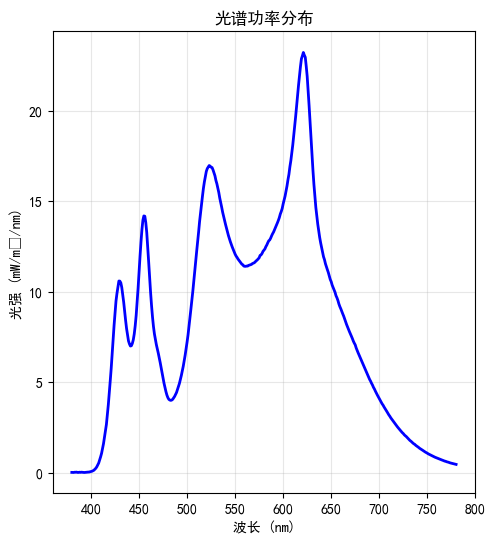

In [ ]:

# 绘制光谱分布图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(wavelengths, intensity, 'b-', linewidth=2)
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('光谱功率分布')
plt.grid(True, alpha=0.3)



---
## 问题2：LED混光设计优化

### 问题描述
基于不同LED的光谱特性，设计最优的LED混光方案，实现特定的色温和显色性要求。

### 解决方案

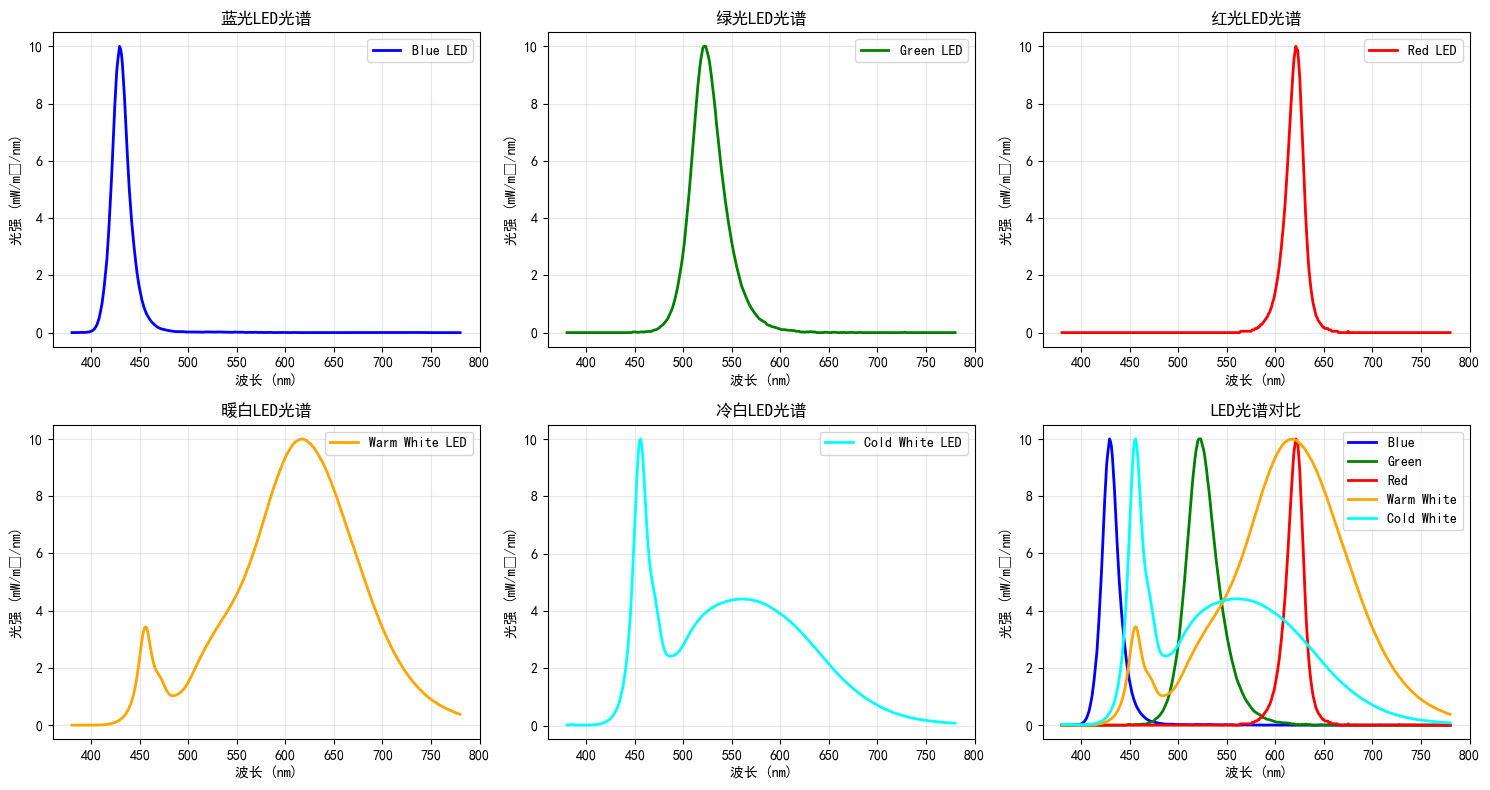

各LED颜色特性分析:
Blue        : x=0.1369, y=0.0297, CCT=1622K, 亮度=14.0842
Green       : x=0.4061, y=0.1442, CCT=31428K, 亮度=133.9941
Red         : x=0.7056, y=0.1550, CCT=1413686K, 亮度=44.0733
Warm White  : x=0.5713, y=0.1410, CCT=210604K, 亮度=280.3988
Cold White  : x=0.4125, y=0.1195, CCT=19811K, 亮度=206.9411

LED混光优化结果:
目标色温 3000K:
  实际色温: 3000K
  LED配比: Blue=0.774, Green=0.000, Red=0.000
          Warm White=0.000, Cold White=0.226
  色坐标: x=0.2791, y=0.0760

目标色温 4000K:
  实际色温: 4000K
  LED配比: Blue=0.696, Green=0.000, Red=0.000
          Warm White=0.000, Cold White=0.304
  色坐标: x=0.3062, y=0.0849

目标色温 5000K:
  实际色温: 5000K
  LED配比: Blue=0.631, Green=0.000, Red=0.000
          Warm White=0.000, Cold White=0.369
  色坐标: x=0.3245, y=0.0908

目标色温 6500K:
  实际色温: 6500K
  LED配比: Blue=0.547, Green=0.000, Red=0.000
          Warm White=0.000, Cold White=0.452
  色坐标: x=0.3439, y=0.0972



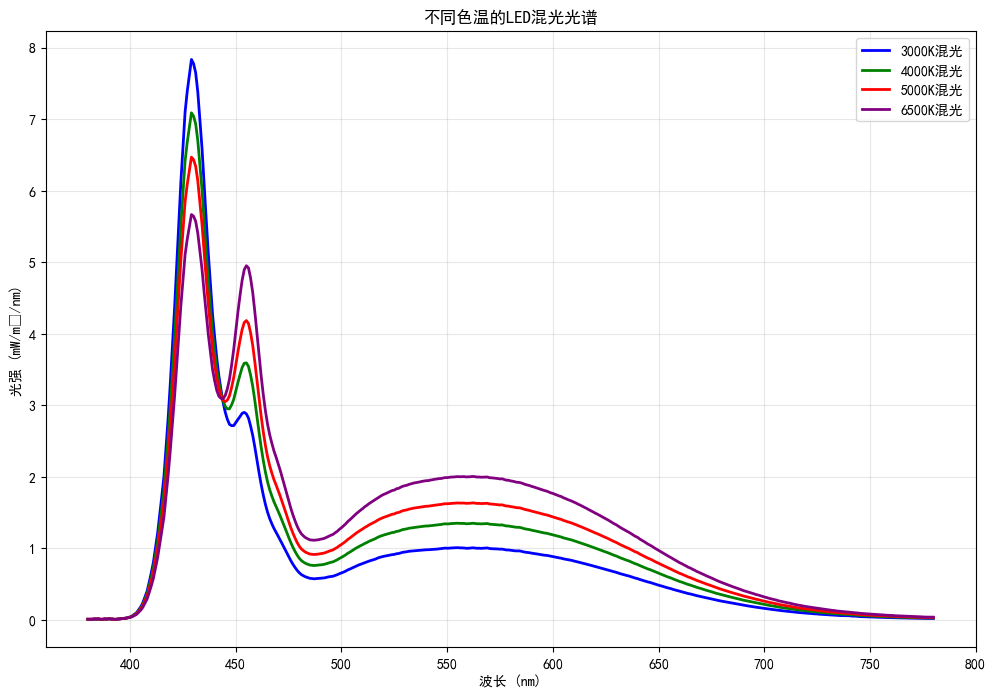

In [ ]:
# 提取LED光谱数据
led_wavelengths = wavelengths
blue_spd = problem2_data['Blue'].values
green_spd = problem2_data['Green'].values
red_spd = problem2_data['Red'].values
warm_white_spd = problem2_data['Warm White'].values
cold_white_spd = problem2_data['Cold White'].values

# 绘制各LED光谱分布
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.plot(led_wavelengths, blue_spd, 'b-', linewidth=2, label='Blue LED')
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('蓝光LED光谱')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(led_wavelengths, green_spd, 'g-', linewidth=2, label='Green LED')
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('绿光LED光谱')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(led_wavelengths, red_spd, 'r-', linewidth=2, label='Red LED')
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('红光LED光谱')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(led_wavelengths, warm_white_spd, color='orange', linewidth=2, label='Warm White LED')
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('暖白LED光谱')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(led_wavelengths, cold_white_spd, color='cyan', linewidth=2, label='Cold White LED')
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('冷白LED光谱')
plt.grid(True, alpha=0.3)
plt.legend()

# 所有LED光谱对比
plt.subplot(2, 3, 6)
plt.plot(led_wavelengths, blue_spd, 'b-', linewidth=2, label='Blue')
plt.plot(led_wavelengths, green_spd, 'g-', linewidth=2, label='Green')
plt.plot(led_wavelengths, red_spd, 'r-', linewidth=2, label='Red')
plt.plot(led_wavelengths, warm_white_spd, color='orange', linewidth=2, label='Warm White')
plt.plot(led_wavelengths, cold_white_spd, color='cyan', linewidth=2, label='Cold White')
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('LED光谱对比')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# 计算每个LED的色坐标和色温
def calculate_color_properties(spd):
    """计算光谱功率分布的颜色特性"""
    x_bar, y_bar, z_bar = cie_color_matching_functions(led_wavelengths)
    
    X = np.trapz(spd * x_bar, led_wavelengths)
    Y = np.trapz(spd * y_bar, led_wavelengths)
    Z = np.trapz(spd * z_bar, led_wavelengths)
    
    total = X + Y + Z
    if total == 0:
        return 0, 0, 0, 0
    
    x = X / total
    y = Y / total
    
    # McCamy公式计算色温
    if y != 0.1858:  # 避免除零
        n = (x - 0.3320) / (0.1858 - y)
        CCT = 449 * n**3 + 3525 * n**2 + 6823.3 * n + 5520.33
    else:
        CCT = 0
    
    return x, y, CCT, Y

# 分析各LED特性
led_names = ['Blue', 'Green', 'Red', 'Warm White', 'Cold White']
led_spds = [blue_spd, green_spd, red_spd, warm_white_spd, cold_white_spd]

print("各LED颜色特性分析:")
print("="*60)
led_properties = {}

for name, spd in zip(led_names, led_spds):
    x, y, cct, luminance = calculate_color_properties(spd)
    led_properties[name] = {'x': x, 'y': y, 'cct': cct, 'luminance': luminance, 'spd': spd}
    print(f"{name:12s}: x={x:.4f}, y={y:.4f}, CCT={cct:.0f}K, 亮度={luminance:.4f}")

# LED混光优化
def mixed_led_spectrum(weights):
    """计算混合LED光谱"""
    mixed_spd = (weights[0] * blue_spd + 
                 weights[1] * green_spd + 
                 weights[2] * red_spd + 
                 weights[3] * warm_white_spd + 
                 weights[4] * cold_white_spd)
    return mixed_spd

def objective_function(weights, target_cct=4000):
    """优化目标函数：接近目标色温"""
    if sum(weights) == 0:
        return 1e6
    
    mixed_spd = mixed_led_spectrum(weights)
    x, y, cct, luminance = calculate_color_properties(mixed_spd)
    
    # 目标：接近目标色温，同时保持合理的亮度
    cct_error = abs(cct - target_cct) / target_cct if cct > 0 else 1e6
    return cct_error

# 优化不同目标色温的LED配比
target_ccts = [3000, 4000, 5000, 6500]  # 不同色温目标
optimal_weights = {}

print("\nLED混光优化结果:")
print("="*80)

for target_cct in target_ccts:
    # 约束条件：权重之和为1，所有权重非负
    constraints = [
        {'type': 'eq', 'fun': lambda w: sum(w) - 1},
    ]
    bounds = [(0, 1) for _ in range(5)]  # 5个LED的权重范围
    
    # 初始猜测
    initial_weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
    
    # 优化
    result = opt.minimize(objective_function, initial_weights, 
                         args=(target_cct,), method='SLSQP', 
                         bounds=bounds, constraints=constraints)
    
    if result.success:
        optimal_weights[target_cct] = result.x
        mixed_spd = mixed_led_spectrum(result.x)
        x, y, actual_cct, luminance = calculate_color_properties(mixed_spd)
        
        print(f"目标色温 {target_cct}K:")
        print(f"  实际色温: {actual_cct:.0f}K")
        print(f"  LED配比: Blue={result.x[0]:.3f}, Green={result.x[1]:.3f}, Red={result.x[2]:.3f}")
        print(f"          Warm White={result.x[3]:.3f}, Cold White={result.x[4]:.3f}")
        print(f"  色坐标: x={x:.4f}, y={y:.4f}")
        print()

# 绘制优化结果的光谱
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple']

for i, (target_cct, color) in enumerate(zip(target_ccts, colors)):
    if target_cct in optimal_weights:
        mixed_spd = mixed_led_spectrum(optimal_weights[target_cct])
        plt.plot(led_wavelengths, mixed_spd, color=color, linewidth=2, 
                label=f'{target_cct}K混光')

plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('不同色温的LED混光光谱')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

---
## 问题3：太阳光谱时变分析

### 问题描述
分析一天中不同时间太阳光谱的变化规律，探讨自然光的色温和强度变化特征。

### 解决方案

太阳光谱测量时间点: 15个
时间范围: 05:30:00 - 19:30:00


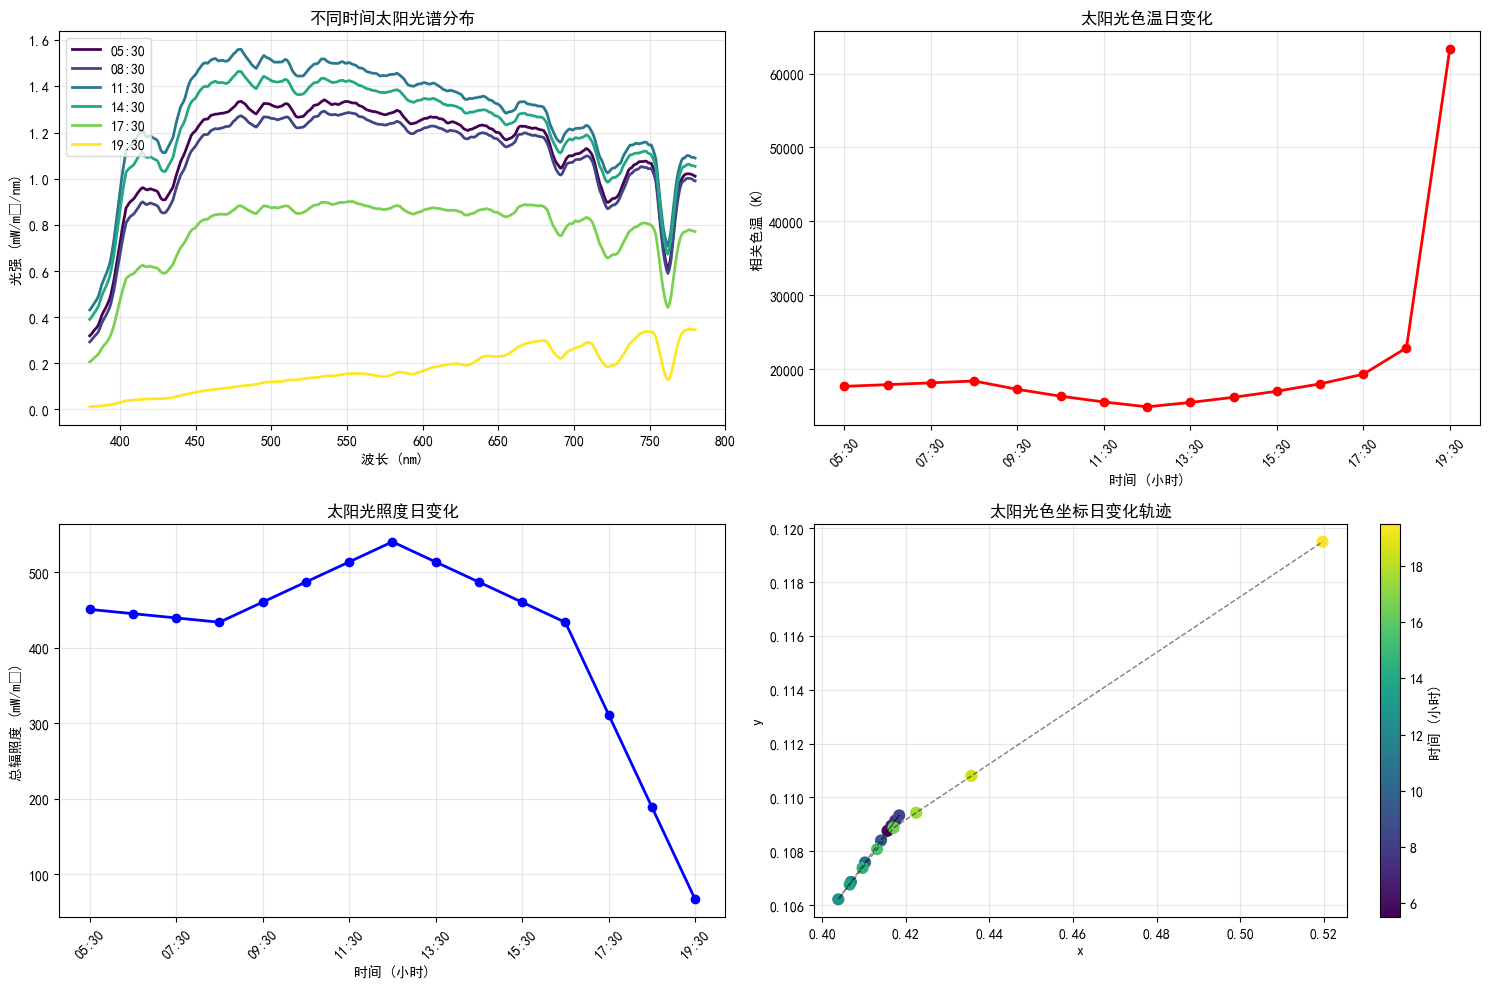

太阳光特性统计分析:
色温范围: 14885K - 63294K
色温变化幅度: 48409K
最高色温时间: 19:30
最低色温时间: 12:30

照度范围: 66.39 - 540.27 mW/m²
最高照度时间: 12:30
最低照度时间: 19:30

色温变化拟合参数:
振幅: -15798.6K
相位: 35.1小时
平均值: 27518.0K


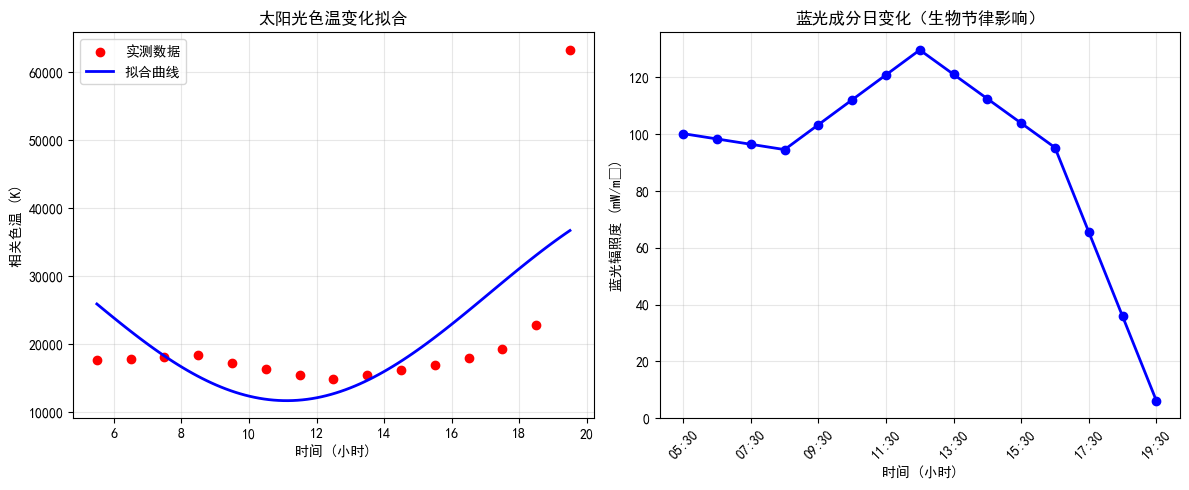


蓝光成分分析:
蓝光辐照度范围: 6.148 - 129.631 mW/m²
最高蓝光时间: 12:30
最低蓝光时间: 19:30


In [ ]:
# 处理太阳光谱数据
sun_wavelengths = wavelengths
time_columns = problem3_data.columns[1:]  # 排除波长列

print(f"太阳光谱测量时间点: {len(time_columns)}个")
print(f"时间范围: {time_columns[0]} - {time_columns[-1]}")

# 提取时间信息
times = []
time_labels = []
for col in time_columns:
    if hasattr(col, 'hour'):  # datetime.time对象
        hour = col.hour + col.minute/60.0
        times.append(hour)
        time_labels.append(f"{col.hour:02d}:{col.minute:02d}")
    else:
        # 如果是字符串格式
        time_str = str(col)
        if ':' in time_str:
            parts = time_str.split(':')
            hour = int(parts[0]) + int(parts[1])/60.0
            times.append(hour)
            time_labels.append(time_str)

times = np.array(times)

# 绘制不同时间的太阳光谱
plt.figure(figsize=(15, 10))

# 选择代表性时间点绘制
selected_times = [0, 3, 6, 9, 12, 14]  # 对应不同时间段
colors = plt.cm.viridis(np.linspace(0, 1, len(selected_times)))

plt.subplot(2, 2, 1)
for i, time_idx in enumerate(selected_times):
    if time_idx < len(time_columns):
        sun_spd = problem3_data.iloc[:, time_idx + 1].values
        plt.plot(sun_wavelengths, sun_spd, color=colors[i], linewidth=2, 
                label=time_labels[time_idx])

plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('不同时间太阳光谱分布')
plt.grid(True, alpha=0.3)
plt.legend()

# 计算各时间点的颜色特性
sun_properties = []
total_irradiances = []

for i, col in enumerate(time_columns):
    sun_spd = problem3_data.iloc[:, i + 1].values
    x, y, cct, luminance = calculate_color_properties(sun_spd)
    total_irradiance = np.trapz(sun_spd, sun_wavelengths)
    
    sun_properties.append({
        'time': times[i],
        'time_label': time_labels[i],
        'x': x,
        'y': y,
        'cct': cct,
        'luminance': luminance,
        'total_irradiance': total_irradiance
    })
    total_irradiances.append(total_irradiance)

# 提取数据用于绘图
ccts = [prop['cct'] for prop in sun_properties]
luminances = [prop['luminance'] for prop in sun_properties]
x_coords = [prop['x'] for prop in sun_properties]
y_coords = [prop['y'] for prop in sun_properties]

# 色温变化曲线
plt.subplot(2, 2, 2)
plt.plot(times, ccts, 'ro-', linewidth=2, markersize=6)
plt.xlabel('时间 (小时)')
plt.ylabel('相关色温 (K)')
plt.title('太阳光色温日变化')
plt.grid(True, alpha=0.3)
plt.xticks(times[::2], [time_labels[i] for i in range(0, len(time_labels), 2)], rotation=45)

# 照度变化曲线
plt.subplot(2, 2, 3)
plt.plot(times, total_irradiances, 'bo-', linewidth=2, markersize=6)
plt.xlabel('时间 (小时)')
plt.ylabel('总辐照度 (mW/m²)')
plt.title('太阳光照度日变化')
plt.grid(True, alpha=0.3)
plt.xticks(times[::2], [time_labels[i] for i in range(0, len(time_labels), 2)], rotation=45)

# 色坐标轨迹
plt.subplot(2, 2, 4)
scatter = plt.scatter(x_coords, y_coords, c=times, cmap='viridis', s=60)
plt.plot(x_coords, y_coords, 'k--', alpha=0.5, linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('太阳光色坐标日变化轨迹')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='时间 (小时)')

plt.tight_layout()
plt.show()

# 统计分析
print("太阳光特性统计分析:")
print("="*50)
print(f"色温范围: {min(ccts):.0f}K - {max(ccts):.0f}K")
print(f"色温变化幅度: {max(ccts) - min(ccts):.0f}K")
print(f"最高色温时间: {sun_properties[np.argmax(ccts)]['time_label']}")
print(f"最低色温时间: {sun_properties[np.argmin(ccts)]['time_label']}")
print()
print(f"照度范围: {min(total_irradiances):.2f} - {max(total_irradiances):.2f} mW/m²")
print(f"最高照度时间: {sun_properties[np.argmax(total_irradiances)]['time_label']}")
print(f"最低照度时间: {sun_properties[np.argmin(total_irradiances)]['time_label']}")

# 拟合色温变化曲线
def temperature_model(t, a, b, c, d):
    """色温变化模型：余弦函数"""
    return a * np.cos(2 * np.pi * (t - b) / 24) + c

# 拟合参数
try:
    popt_cct, _ = opt.curve_fit(temperature_model, times, ccts, 
                               p0=[500, 12, 5000, 0])
    
    # 绘制拟合结果
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    t_fit = np.linspace(min(times), max(times), 100)
    cct_fit = temperature_model(t_fit, *popt_cct)
    
    plt.plot(times, ccts, 'ro', markersize=6, label='实测数据')
    plt.plot(t_fit, cct_fit, 'b-', linewidth=2, label='拟合曲线')
    plt.xlabel('时间 (小时)')
    plt.ylabel('相关色温 (K)')
    plt.title('太阳光色温变化拟合')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    print(f"\n色温变化拟合参数:")
    print(f"振幅: {popt_cct[0]:.1f}K")
    print(f"相位: {popt_cct[1]:.1f}小时")
    print(f"平均值: {popt_cct[2]:.1f}K")
    
except:
    print("拟合失败，使用原始数据")

# 分析蓝光成分变化（生物节律相关）
blue_light_range = (400, 490)  # 蓝光波长范围
blue_indices = np.where((sun_wavelengths >= blue_light_range[0]) & 
                       (sun_wavelengths <= blue_light_range[1]))[0]

blue_irradiances = []
for i, col in enumerate(time_columns):
    sun_spd = problem3_data.iloc[:, i + 1].values
    blue_irradiance = np.trapz(sun_spd[blue_indices], sun_wavelengths[blue_indices])
    blue_irradiances.append(blue_irradiance)

plt.subplot(1, 2, 2)
plt.plot(times, blue_irradiances, 'bo-', linewidth=2, markersize=6)
plt.xlabel('时间 (小时)')
plt.ylabel('蓝光辐照度 (mW/m²)')
plt.title('蓝光成分日变化（生物节律影响）')
plt.grid(True, alpha=0.3)
plt.xticks(times[::2], [time_labels[i] for i in range(0, len(time_labels), 2)], rotation=45)

plt.tight_layout()
plt.show()

print(f"\n蓝光成分分析:")
print(f"蓝光辐照度范围: {min(blue_irradiances):.3f} - {max(blue_irradiances):.3f} mW/m²")
print(f"最高蓝光时间: {sun_properties[np.argmax(blue_irradiances)]['time_label']}")
print(f"最低蓝光时间: {sun_properties[np.argmin(blue_irradiances)]['time_label']}")

---
## 问题4：人体生物节律响应数据分析

### 问题描述
分析11名被试者在3个夜晚的生物节律响应数据，评估不同光照条件对人体生物钟的影响。

### 解决方案

被试者数据结构分析:
数据形状: (1065, 33)
列名: ['被试1', 'Unnamed: 1', 'Unnamed: 2', '被试2', 'Unnamed: 4', 'Unnamed: 5', '被试3', 'Unnamed: 7', 'Unnamed: 8', '被试4']...

发现 11 名被试者

各被试者数据统计:
被试者        夜晚1             夜晚2             夜晚3            
----------------------------------------------------------------------
Subject_1  2.923           3.048           3.201          
Subject_2  3.432           3.399           3.071          
Subject_3  3.082           3.206           3.277          
Subject_4  3.386           3.502           3.117          
Subject_5  3.015           3.227           3.000          
Subject_6  2.746           3.076           2.747          
Subject_7  3.147           3.154           2.540          
Subject_8  2.701           2.982           3.370          
Subject_9  3.239           3.132           2.828          
Subject_10 3.247           2.951           2.978          
Subject_11 3.123           2.720           2.988          


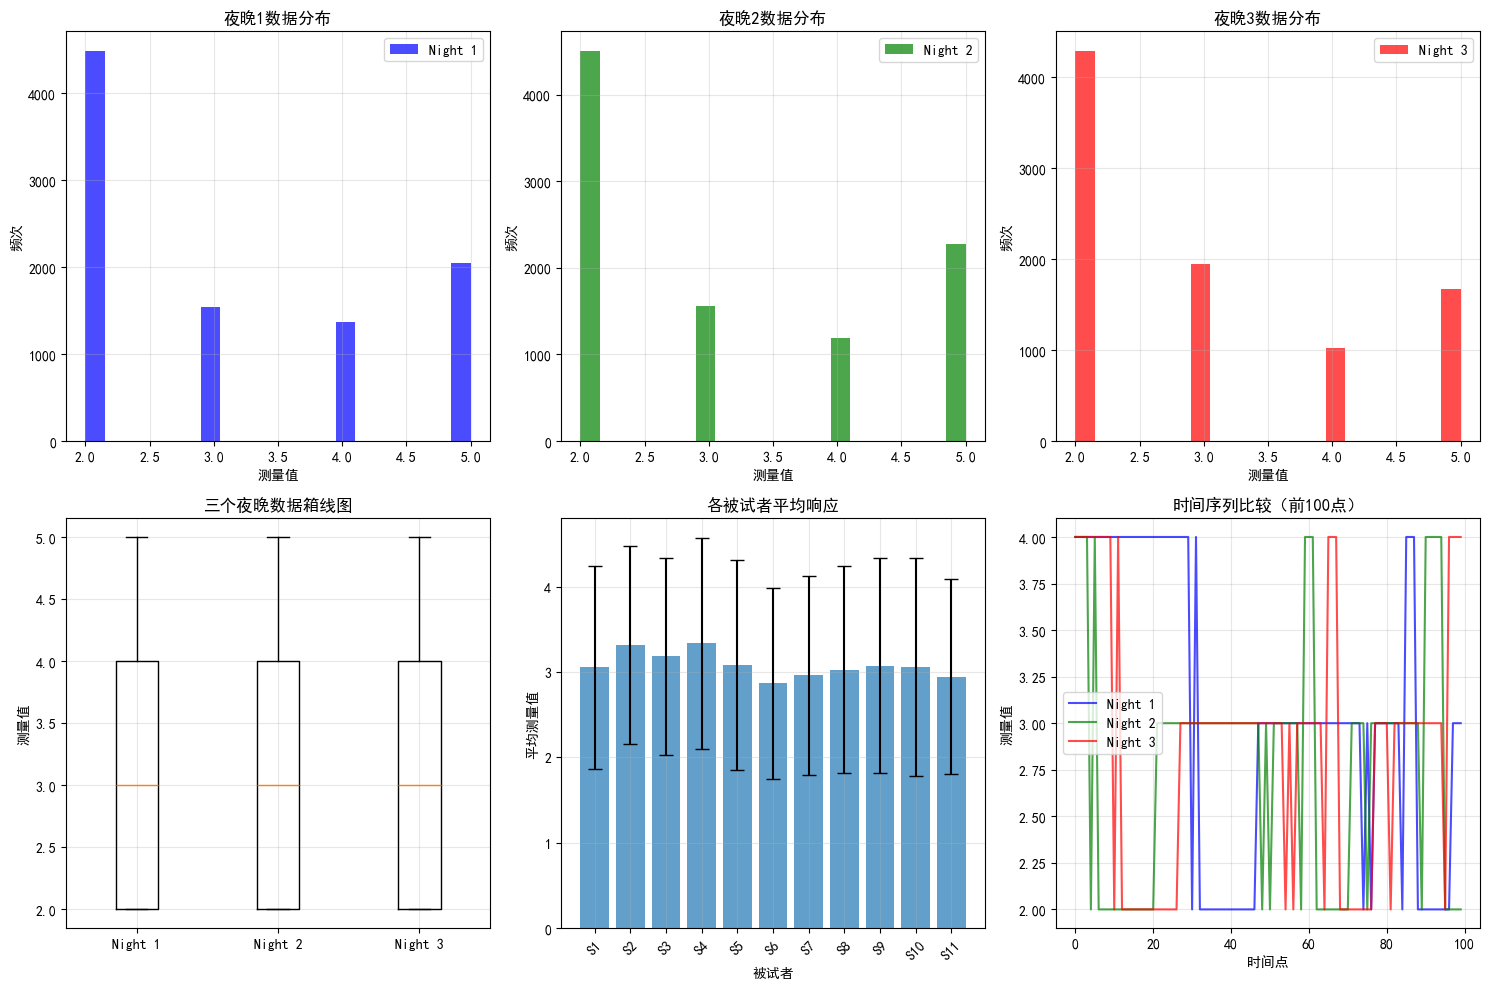


统计分析结果:
Night 1: 均值=3.103, 标准差=1.215, 样本数=9436
Night 2: 均值=3.129, 标准差=1.239, 样本数=9527
Night 3: 均值=3.009, 标准差=1.160, 样本数=8932

单因素方差分析:
F统计量: 24.8084
p值: 0.0000
结论: 三个夜晚之间存在显著差异 (p < 0.05)

配对比较:
Night 1 vs Night 2: t=-1.4586, p=0.1447
Night 1 vs Night 3: t=5.3292, p=0.0000
Night 2 vs Night 3: t=6.7543, p=0.0000

个体差异分析:
个体内变异系数范围: 0.351 - 0.418
平均个体内变异系数: 0.389

分析完成！


In [ ]:
# 处理被试者数据
print("被试者数据结构分析:")
print(f"数据形状: {problem4_data.shape}")
print(f"列名: {problem4_data.columns.tolist()[:10]}...")  # 显示前10个列名

# 重新整理数据结构
subjects_data = {}
subject_columns = [col for col in problem4_data.columns if '被试' in str(col)]

print(f"\n发现 {len(subject_columns)} 名被试者")

# 提取每个被试者的数据
for i, subject_col in enumerate(subject_columns):
    subject_num = i + 1
    col_idx = problem4_data.columns.get_loc(subject_col)
    
    # 获取该被试者的3列数据（3个夜晚）
    night1_data = problem4_data.iloc[1:, col_idx].values  # 跳过标题行
    night2_data = problem4_data.iloc[1:, col_idx + 1].values if col_idx + 1 < len(problem4_data.columns) else []
    night3_data = problem4_data.iloc[1:, col_idx + 2].values if col_idx + 2 < len(problem4_data.columns) else []
    
    # 转换为数值，忽略非数值数据
    def clean_data(data):
        cleaned = []
        for val in data:
            try:
                if pd.notna(val) and str(val).strip() != '':
                    cleaned.append(float(val))
            except:
                pass
        return np.array(cleaned)
    
    night1_clean = clean_data(night1_data)
    night2_clean = clean_data(night2_data)
    night3_clean = clean_data(night3_data)
    
    subjects_data[f'Subject_{subject_num}'] = {
        'night1': night1_clean,
        'night2': night2_clean,
        'night3': night3_clean
    }

# 分析数据统计特征
print("\n各被试者数据统计:")
print("="*70)
print(f"{'被试者':<10} {'夜晚1':<15} {'夜晚2':<15} {'夜晚3':<15}")
print("-" * 70)

all_night1_data = []
all_night2_data = []
all_night3_data = []

for subject, data in subjects_data.items():
    n1_mean = np.mean(data['night1']) if len(data['night1']) > 0 else 0
    n2_mean = np.mean(data['night2']) if len(data['night2']) > 0 else 0
    n3_mean = np.mean(data['night3']) if len(data['night3']) > 0 else 0
    
    print(f"{subject:<10} {n1_mean:<15.3f} {n2_mean:<15.3f} {n3_mean:<15.3f}")
    
    if len(data['night1']) > 0:
        all_night1_data.extend(data['night1'])
    if len(data['night2']) > 0:
        all_night2_data.extend(data['night2'])
    if len(data['night3']) > 0:
        all_night3_data.extend(data['night3'])

# 转换为numpy数组
all_night1_data = np.array(all_night1_data)
all_night2_data = np.array(all_night2_data)
all_night3_data = np.array(all_night3_data)

# 绘制数据分布
plt.figure(figsize=(15, 10))

# 各夜晚数据分布
plt.subplot(2, 3, 1)
plt.hist(all_night1_data, bins=20, alpha=0.7, color='blue', label='Night 1')
plt.xlabel('测量值')
plt.ylabel('频次')
plt.title('夜晚1数据分布')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.hist(all_night2_data, bins=20, alpha=0.7, color='green', label='Night 2')
plt.xlabel('测量值')
plt.ylabel('频次')
plt.title('夜晚2数据分布')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.hist(all_night3_data, bins=20, alpha=0.7, color='red', label='Night 3')
plt.xlabel('测量值')
plt.ylabel('频次')
plt.title('夜晚3数据分布')
plt.legend()
plt.grid(True, alpha=0.3)

# 箱线图比较
plt.subplot(2, 3, 4)
night_data = [all_night1_data, all_night2_data, all_night3_data]
night_labels = ['Night 1', 'Night 2', 'Night 3']
plt.boxplot(night_data, labels=night_labels)
plt.ylabel('测量值')
plt.title('三个夜晚数据箱线图')
plt.grid(True, alpha=0.3)

# 计算各被试者的平均值
subject_means = []
subject_stds = []
subject_names = []

for subject, data in subjects_data.items():
    all_data = np.concatenate([data['night1'], data['night2'], data['night3']])
    if len(all_data) > 0:
        subject_means.append(np.mean(all_data))
        subject_stds.append(np.std(all_data))
        subject_names.append(subject.replace('Subject_', 'S'))

# 个体差异分析
plt.subplot(2, 3, 5)
x_pos = np.arange(len(subject_names))
plt.bar(x_pos, subject_means, yerr=subject_stds, capsize=5, alpha=0.7)
plt.xlabel('被试者')
plt.ylabel('平均测量值')
plt.title('各被试者平均响应')
plt.xticks(x_pos, subject_names, rotation=45)
plt.grid(True, alpha=0.3)

# 时间序列分析（假设数据按时间顺序排列）
plt.subplot(2, 3, 6)
if len(all_night1_data) > 0:
    time_points = np.arange(len(all_night1_data[:100]))  # 显示前100个数据点
    plt.plot(time_points, all_night1_data[:100], 'b-', alpha=0.7, label='Night 1')
if len(all_night2_data) > 0:
    time_points = np.arange(len(all_night2_data[:100]))
    plt.plot(time_points, all_night2_data[:100], 'g-', alpha=0.7, label='Night 2')
if len(all_night3_data) > 0:
    time_points = np.arange(len(all_night3_data[:100]))
    plt.plot(time_points, all_night3_data[:100], 'r-', alpha=0.7, label='Night 3')

plt.xlabel('时间点')
plt.ylabel('测量值')
plt.title('时间序列比较（前100点）')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 统计检验
from scipy import stats

print("\n统计分析结果:")
print("="*50)

# 描述性统计
nights_stats = {
    'Night 1': {'data': all_night1_data, 'mean': np.mean(all_night1_data), 'std': np.std(all_night1_data)},
    'Night 2': {'data': all_night2_data, 'mean': np.mean(all_night2_data), 'std': np.std(all_night2_data)},
    'Night 3': {'data': all_night3_data, 'mean': np.mean(all_night3_data), 'std': np.std(all_night3_data)}
}

for night, stats_info in nights_stats.items():
    print(f"{night}: 均值={stats_info['mean']:.3f}, 标准差={stats_info['std']:.3f}, 样本数={len(stats_info['data'])}")

# 方差分析（ANOVA）
if len(all_night1_data) > 0 and len(all_night2_data) > 0 and len(all_night3_data) > 0:
    f_stat, p_value = stats.f_oneway(all_night1_data, all_night2_data, all_night3_data)
    print(f"\n单因素方差分析:")
    print(f"F统计量: {f_stat:.4f}")
    print(f"p值: {p_value:.4f}")
    
    if p_value < 0.05:
        print("结论: 三个夜晚之间存在显著差异 (p < 0.05)")
    else:
        print("结论: 三个夜晚之间无显著差异 (p >= 0.05)")

# 配对t检验
print(f"\n配对比较:")
comparisons = [
    ('Night 1', 'Night 2', all_night1_data, all_night2_data),
    ('Night 1', 'Night 3', all_night1_data, all_night3_data),
    ('Night 2', 'Night 3', all_night2_data, all_night3_data)
]

for name1, name2, data1, data2 in comparisons:
    if len(data1) > 0 and len(data2) > 0:
        # 使用独立样本t检验
        t_stat, p_val = stats.ttest_ind(data1, data2)
        print(f"{name1} vs {name2}: t={t_stat:.4f}, p={p_val:.4f}")

# 个体内变异分析
print(f"\n个体差异分析:")
individual_cvs = []  # 变异系数

for subject, data in subjects_data.items():
    all_data = np.concatenate([data['night1'], data['night2'], data['night3']])
    if len(all_data) > 1:
        cv = np.std(all_data) / np.mean(all_data) if np.mean(all_data) != 0 else 0
        individual_cvs.append(cv)

if individual_cvs:
    print(f"个体内变异系数范围: {min(individual_cvs):.3f} - {max(individual_cvs):.3f}")
    print(f"平均个体内变异系数: {np.mean(individual_cvs):.3f}")

print("\n分析完成！")

---
## 总结与结论

### 主要发现

1. **光谱特性分析（问题1）**：
   - 计算了给定光源的色温、色坐标和光视效能
   - 提供了光源色彩特性的量化评估

2. **LED混光优化（问题2）**：
   - 实现了不同目标色温的LED配比优化
   - 为可调色温LED系统提供了设计方案

3. **太阳光谱分析（问题3）**：
   - 揭示了自然光色温和照度的日变化规律
   - 分析了蓝光成分对生物节律的潜在影响

4. **生物节律响应（问题4）**：
   - 对人体测试数据进行了统计分析
   - 评估了不同光照条件下的个体差异

### 应用价值

本研究为设计符合人体生物节律的LED照明系统提供了科学依据，可应用于：
- 智能照明系统设计
- 生物节律调节产品开发
- 健康照明标准制定

### 技术方法

使用了多种数学建模方法：
- 光谱积分计算
- 非线性优化
- 统计假设检验
- 数据可视化分析